### Activation Maximization

In [ ]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import timm
import torch
import detectors
from torchvision import transforms
from utils import vis as vis

In [2]:
import os
from tqdm import tqdm

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset

In [3]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/ffcv'
model_path      = '/tmp/zooming_in_on_mlps/'
eval_batch_size = 32
crop_resolution = 32
data_resolution = 32 
checkpoint      = None
device          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 64   

In [4]:
def get_models_full(model_type, 
                    architecture, 
                    resolution  = crop_resolution, 
                    num_classes = CLASS_DICT[dataset], 
                    checkpoint  = checkpoint, 
                    model_path   = model_path):
    if model_type == 'mlp':
        model = get_model(architecture=architecture, resolution = resolution, 
                          num_classes=num_classes,checkpoint= checkpoint)
        model = torch.nn.Sequential(vis.Reshape(64), model)
    elif model_type == 'cnn':
        model = timm.create_model(architecture, pretrained=True)
    elif model_type == 'vit':
        model = torch.load(os.path.join(model_path, architecture))
        model = torch.nn.Sequential(vis.Reshape(224), model)
    return model

In [ ]:

model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 32 

# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image1, synthetic_image1 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 250, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

In [ ]:
model_type      = 'cnn'               
architecture    = 'resnet18_' + dataset                      
crop_resolution = 32 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image2, synthetic_image2 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 250, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

In [ ]:
model_type      = 'vit'                  
architecture    = 'vit_small_patch16_224_' + dataset + '_v7.pth'        
crop_resolution = 224 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

# for activation maximization. Start from total random noise or use
# an initial image instead
use_init_image = True

# generate image using activation maximization
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

if use_init_image == False:
    img   = None
    label = 0
else:
    label = label.item()

init_image3, synthetic_image3 = vis.generate_image(model        = model, 
                                     target_class = label,
                                     epochs       = 150, 
                                     min_prob     = 0.9, 
                                     lr           = .01, 
                                     weight_decay = 5e-2, 
                                     step_size    = 100, 
                                     gamma        = 0.9,
                                     noise_size   = crop_resolution,
                                     model_type   = model_type,
                                     img          = img,
                                     dataset      = dataset)

In [117]:
print(f'norm original image mlp {torch.norm(init_image1 - synthetic_image1)}')
print(f'norm original image cnn {torch.norm(init_image2 - synthetic_image2)}')
print(f'norm original image vit {torch.norm(init_image3 - synthetic_image3)}')

norm original image mlp 0.705284059047699
norm original image mlp 0.0
norm original image mlp 0.08486096560955048


### Feature Inversion

In [1]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import timm
import torch
import detectors
from torchvision import transforms
from utils import vis as vis

/home/kvergopoulos/miniconda3/envs/ffcv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from tqdm import tqdm

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset

In [20]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/ffcv'
model_path      = '/scratch/zooming_in_on_mlps'
eval_batch_size = 32
crop_resolution = 32
data_resolution = 32 
checkpoint      = None
device          = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 64  

In [21]:
def get_models_full(model_type, 
                    architecture, 
                    resolution  = crop_resolution, 
                    num_classes = CLASS_DICT[dataset], 
                    checkpoint  = checkpoint, 
                    model_path   = model_path):
    if model_type == 'mlp':
        model = get_model(architecture=architecture, resolution = resolution, 
                          num_classes=num_classes,checkpoint= checkpoint)
        model = torch.nn.Sequential(vis.Reshape(64), model)
    elif model_type == 'cnn':
        model = timm.create_model(architecture, pretrained=True)
    elif model_type == 'vit':
        model = torch.load(os.path.join(model_path, architecture))
        model = torch.nn.Sequential(vis.Reshape(224), model)
    return model

In [33]:
#model_type      = 'vit'                  
#architecture    = 'vit_small_patch16_224_' + dataset + '_7.pth'        
#crop_resolution = 32 

model_type      = 'cnn'               
architecture    = 'resnet18_' + dataset                      
crop_resolution = 32 

#model_type      = 'mlp'                   
#checkpoint      = 'in21k_cifar10'       
#architecture    = 'B_12-Wi_1024'        
#crop_resolution = 32 

# load the model
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
model.to(device)
with torch.no_grad():
    model.eval()

# initialize loader
loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )

Loading /scratch/ffcv/cifar10/val_32.beton


In [34]:
if model_type == 'cnn':
    modules = ['conv1', 'layer1.0.conv1']
    
if model_type == 'vit':
    modules = ['1.blocks.0.mlp.fc1', '1.blocks.1.mlp.fc1']

if model_type == 'mlp':
    modules = ['1.blocks.0.block.0', '1.blocks.2.block.0']

In [35]:
dataiter    = iter(loader)
ims, labels = next(dataiter)
img         = ims[1].unsqueeze(0)
label       = labels[1]

0.19560471177101135
0.16023699939250946
0.154584601521492
0.1470758020877838
0.13823260366916656
0.12855516374111176
0.11849583685398102
0.10844196379184723
0.09870674461126328
0.08952704817056656
0.08106610178947449
0.07342033088207245
0.06662864238023758
0.060683056712150574
0.05553976446390152
0.051129795610904694
0.04736873134970665
0.044164977967739105
0.041426606476306915
0.039066411554813385
0.03700556606054306
0.03517577052116394
0.03352026641368866
0.03199384734034538
0.030562162399291992
0.029200488701462746
0.02789224684238434
0.02662738598883152
0.02540079690515995
0.024210907518863678
0.023058420047163963
0.021945351734757423
0.020874250680208206
0.019847678020596504
0.01886783167719841
0.01793636754155159
0.017054283991456032
0.016221925616264343
0.01543901301920414
0.014704706147313118
0.01401769183576107
0.013376254588365555
0.01331464946269989
0.013253591023385525
0.013193062506616116
0.013133048079907894
0.013073544017970562
0.013014552183449268
0.012956071645021439
0

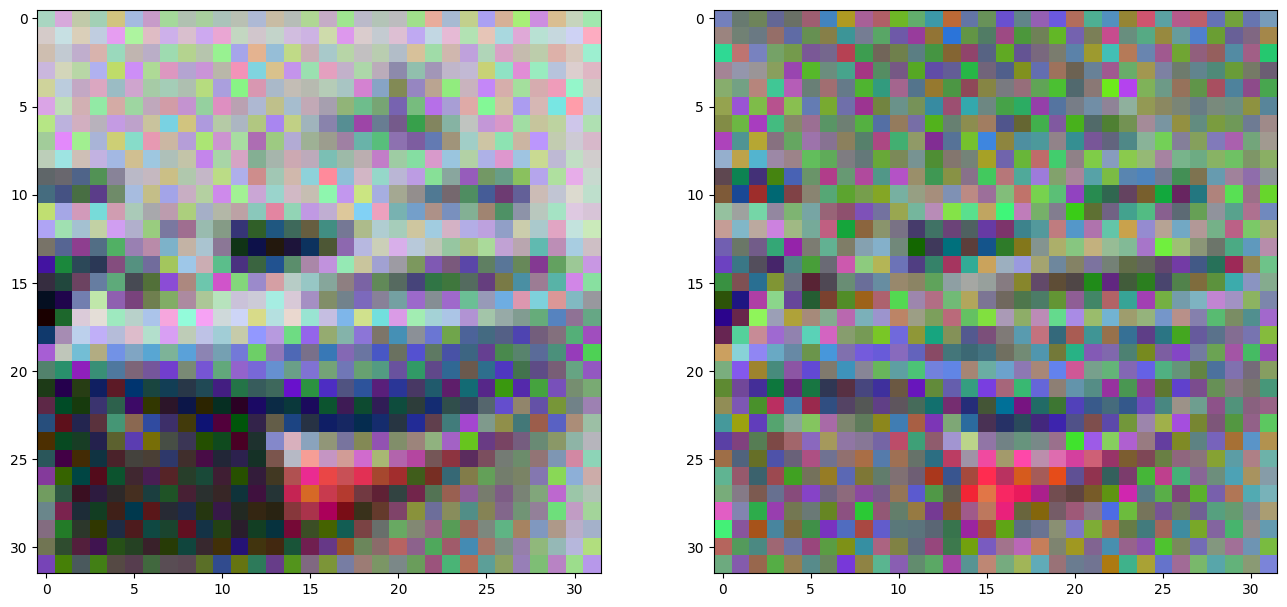

In [36]:
vis.feature_inversion(model         = model, 
                      modules_names = modules, 
                      img           = img,
                      noise_size    = crop_resolution,
                      epochs        = 150, 
                      lr            = 1000,
                      step_size     = 100,
                      gamma         = 0.6,
                      mu            = 1e-1,
                      device        = device,
                      mode          = 1) #1 or 2